# Task 2 - LSTM for time series classification

In [1]:
import numpy as np
import pandas as pd
import re
import os

from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sns.set_style("darkgrid")
sns.set(font_scale=1.3)

In [3]:
# GPU
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.7 GB  | Proc size: 190.0 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Data import & EDA

In [0]:
# files.upload()

In [5]:
FILE_NAME_PREFIX = 'Ambient_Living_'
data_file_pattern = FILE_NAME_PREFIX + r'(?P<seq_id>\d+).csv'
data_files = list(filter(lambda s: re.match(data_file_pattern, s) is not None, os.listdir()))
N_FILES = len(data_files)
N_FILES

216

In [6]:
seq_ids = sorted(int(re.match(data_file_pattern, file_name).group('seq_id')) for file_name in data_files)
print(seq_ids)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216]


In [0]:
def load_file(file_code, strip=False):
    df = pd.read_csv(f'{FILE_NAME_PREFIX}{file_code}.csv')
    
    if strip:
        df.columns = [c.strip() for c in df.columns]
    
    return df

### Data example

In [8]:
seq_id = seq_ids[0]
data_example = load_file(seq_id)
data_example.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
0,-0.90476,-0.48,0.28571,0.30
1,-0.57143,-0.32,0.14286,0.30
2,-0.38095,-0.28,-0.14286,0.35
3,-0.28571,-0.20,-0.47619,0.35
4,-0.14286,-0.20,0.14286,-0.20


In [9]:
data_example.describe()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
count,27.000000,27.000000,27.000000,27.000000
mean,-0.232805,-0.082963,-0.077601,0.088889
std,0.216344,0.185614,0.240700,0.299465
min,-0.904760,-0.600000,-0.619050,-0.800000
25%,-0.309520,-0.200000,-0.285710,-0.075000
50%,-0.142860,-0.040000,-0.047619,0.150000
75%,-0.095238,0.040000,0.142860,0.325000
max,0.000000,0.160000,0.285710,0.500000


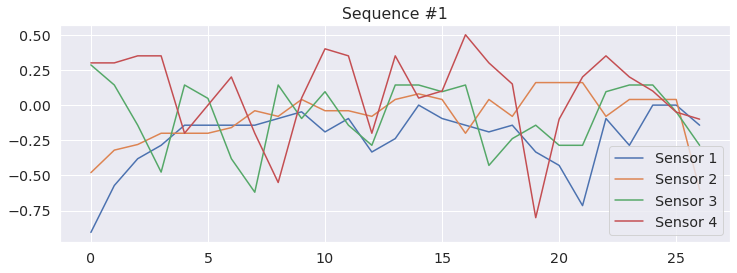

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=data_example, dashes=False)
_ = ax.set_title(f"Sequence #{seq_id}")

### Targets - class labels

In [11]:
# load targets (class labels) for available sequences (only those which have been uploaded)
targets = load_file('target', True).iloc[np.array(seq_ids)-1]
targets.head()

,#sequence_ID,class_label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [12]:
targets['class_label'].value_counts()  # number of classes, class labels, number of examples per class

-1    111
 1    105
Name: class_label, dtype: int64

In [0]:
all_labels = ((targets['class_label'].values + 1)/2).astype("int32")

### All data files

In [0]:
# load data for the available sequences
all_data = [load_file(i) for i in seq_ids]


In [15]:
descr = targets['class_label'].to_frame()
descr.index=targets['#sequence_ID']
descr['length'] = [d.shape[0] for d in all_data]
descr['n_features'] = [d.shape[1] for d in all_data]
descr.head()

,class_label,length,n_features
#sequence_ID,,,
1,1,27,4
2,1,26,4
3,1,23,4
4,1,23,4
5,1,25,4


In [16]:
descr[descr.columns[1:]].describe(percentiles=np.arange(0.2, 1, 0.2))

,length,n_features
count,216.000000,216.0
mean,37.407407,4.0
std,14.948306,0.0
min,19.000000,4.0
20%,24.000000,4.0
40%,27.000000,4.0
50%,33.500000,4.0
60%,40.000000,4.0
80%,54.000000,4.0
max,103.000000,4.0


## Pre-processing
### Adjust sequence lengths to the global 80th quantile

In [17]:
q_cut = 0.8  # cut the length at the 80th quantile
q_cut_value = int(descr['length'].quantile(q_cut))  # get the length corresponding to the quantile
q_cut_value

54

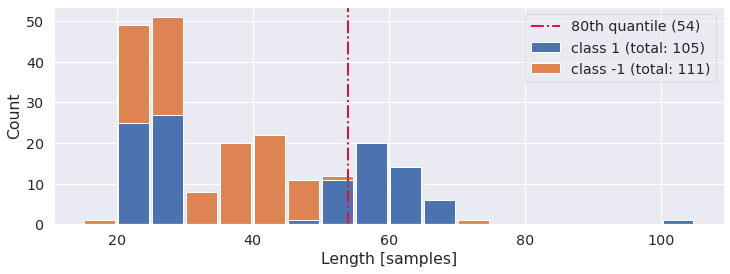

In [18]:
fig, ax = plt.subplots(figsize=(12,4))

w = 5
ln = descr['length']
labels_set = descr['class_label'].unique()
lengths_classes = [ln[descr['class_label'] == label] for label in labels_set]

hist = ax.hist(lengths_classes,
               bins=range(w*(min(ln)//w), max(ln)+w, w),
               label=[f'class {label} (total: {len(lengths_classes[i])})' for i, label in enumerate(labels_set)],
               stacked=True, rwidth=0.9)

ax.axvline(q_cut_value, color='crimson', linestyle='-.', lw=2, label=f'{100*q_cut:.0f}th quantile ({q_cut_value})')

ax.legend(fancybox=True, framealpha=0.5)
ax.set_xlabel("Length [samples]")
ax.set_ylabel("Count")
plt.show()

In [0]:
# prepare array for the pre-processed data (216x54x4)
all_data_prep = np.zeros((len(all_data), q_cut_value, all_data[0].shape[1]))

# fill the array with data for cropped sequences (the padding to 0 is automatic by non-filling the already zero-filled rows)
for i, sequence in enumerate(all_data):
    all_data_prep[i, :min(q_cut_value, sequence.shape[0]), :] = sequence.iloc[:q_cut_value, :]

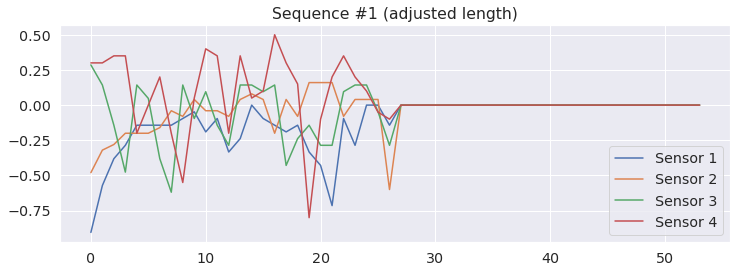

In [20]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=all_data_prep[0], dashes=False)
_ = ax.set_title(f"Sequence #{seq_id} (adjusted length)")
_ = ax.legend(data_example.columns)

## Train-test split
Split the data to training and test sets (in 80-20 proportion). Use a stratified split to preserve the proportion of class labels and fix random state for reproducibility.

The (global) training set will further be split 10 times to (particular) train and validation sets during 10-fold cross-validated grid search.

The test set (holdout set) will be used to evaluate some of the cross-validated models.

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
data_train, data_test, labels_train, labels_test = train_test_split(all_data_prep, all_labels, test_size=0.2,
                                                                    random_state=0, shuffle=True, stratify=all_labels)


In [23]:
print(data_train.shape, data_test.shape, labels_train.shape, labels_test.shape)

(172, 54, 4) (44, 54, 4) (172,) (44,)


## LSTM

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score


In [0]:
# a function defining a model to be evaluated (after wrapping by the Keras)
def make_lstm(my_lstm_units, my_lr, **kwargs):
    lstm_model = Sequential()
    lstm_model.add(layers.LSTM(my_lstm_units, input_shape=all_data_prep.shape[1:]))
    lstm_model.add(layers.Dense(1, activation='sigmoid'))
    
    adam = Adam(lr=my_lr)
    lstm_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return lstm_model

fit_params = dict(epochs=100, verbose=0)


In [0]:
# define the 10-fold cross-validation split
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [0]:
# define a scoring function for the cross validation
def scorer(estimator, X, y):
    return accuracy_score((estimator.predict(X) > 0.5).astype("int32"), y) 


## Grid search

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
param_grid = {'my_lr': [0.0001, 0.001, 0.01], 'batch_size': [N_FILES, N_FILES//3, N_FILES//6], 'my_lstm_units': [64, 128, 256]}

In [30]:
gcv = GridSearchCV(KerasClassifier(make_lstm, **fit_params), param_grid=param_grid, cv=kf, scoring=scorer)
gcv

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f0419e334a8>,
             iid='deprecated', n_jobs=None,
             param_grid={'batch_size': [216, 72, 36],
                         'my_lr': [0.0001, 0.001, 0.01],
                         'my_lstm_units': [64, 128, 256]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function scorer at 0x7f0419e1fc80>, verbose=0)

In [31]:
gcv.fit(data_train, labels_train)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f0419e334a8>,
             iid='deprecated', n_jobs=None,
             param_grid={'batch_size': [216, 72, 36],
                         'my_lr': [0.0001, 0.001, 0.01],
                         'my_lstm_units': [64, 128, 256]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function scorer at 0x7f0419e1fc80>, verbose=0)

In [32]:
gcv_results = pd.DataFrame(gcv.cv_results_['params'])
codes = gcv_results.columns

gcv_results['mean_fit_time'] = gcv.cv_results_['mean_fit_time']
gcv_results['mean_test_score'] = gcv.cv_results_['mean_test_score']
gcv_results.sort_values('mean_test_score', ascending=False, inplace=True)
gcv_results.reset_index(inplace=True)

gcv_results


,index,batch_size,my_lr,my_lstm_units,mean_fit_time,mean_test_score
0,21,36,0.0010,64,7.422129,0.947386
1,23,36,0.0010,256,9.561911,0.917974
2,12,72,0.0010,64,5.046117,0.912092
3,22,36,0.0010,128,8.266995,0.906536
4,19,36,0.0001,128,8.417651,0.901634
5,4,216,0.0010,128,3.953334,0.900654
6,5,216,0.0010,256,4.761226,0.895752
7,3,216,0.0010,64,3.547815,0.894771
8,6,216,0.0100,64,3.459171,0.894771
9,11,72,0.0001,256,7.022231,0.884641


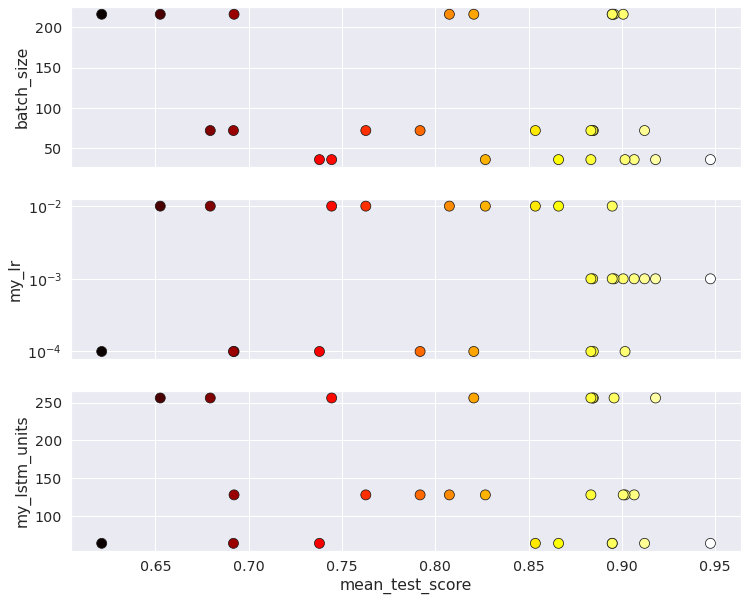

In [33]:
fig, axes = plt.subplots(3, 1, sharex='all', figsize=(12, 10))
for i, ax in enumerate(axes):
    sns.scatterplot(data=gcv_results, x='mean_test_score', y=codes[i], ax=ax, hue='mean_test_score',
                    palette='hot', legend=None, edgecolor='k', s=100)
  
axes[1].set_yscale('log')

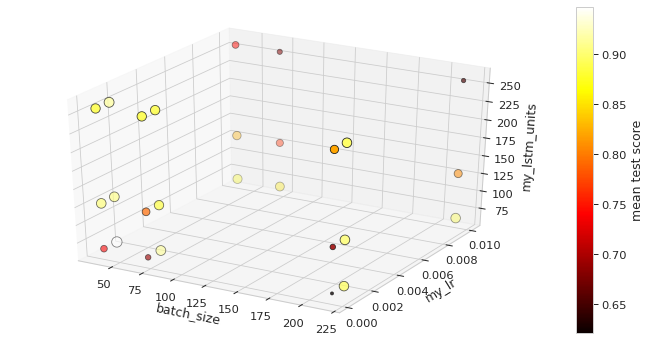

In [34]:
from mpl_toolkits.mplot3d import Axes3D


with sns.plotting_context('paper', font_scale=1.3):
    sns.set_style('whitegrid')

    fig = plt.figure(figsize=(12,6), facecolor=(1, 1, 1))

    ax = fig.add_subplot(111, projection='3d')


    mts = gcv_results['mean_test_score']

    p = ax.scatter(*tuple(gcv_results[code] for code in codes),
                  c=mts, marker='o', cmap='hot', edgecolor='k',
                  s=300*(mts-0.95*mts.min()))
    
    cbar = fig.colorbar(p)
    cbar.set_label('mean test score', rotation=90)


    ax.set_xlabel(codes[0])
    ax.set_ylabel(codes[1])
    ax.set_zlabel(codes[2])

sns.set_style('darkgrid')


## Validation on the test set

In [0]:
def evaluate_model(model_id):

    model_params = dict(gcv_results.loc[model_id, codes])

    for p in ['my_lstm_units', 'batch_size']:
      model_params[p] = int(model_params[p])

    fit_params['batch_size'] = model_params['batch_size']

    model = make_lstm(**model_params)
    model.fit(data_train, labels_train, **fit_params, validation_data=(data_test, labels_test))

    fig, ax = plt.subplots(figsize=(10,4))
    sns.lineplot(data=pd.DataFrame(model.history.history), dashes=False)
    ax.set_title(f"Model {model_id}: {model_params} -> test acc.: {scorer(model, data_test, labels_test):.2f}")
    ax.set_xlabel("Epoch")


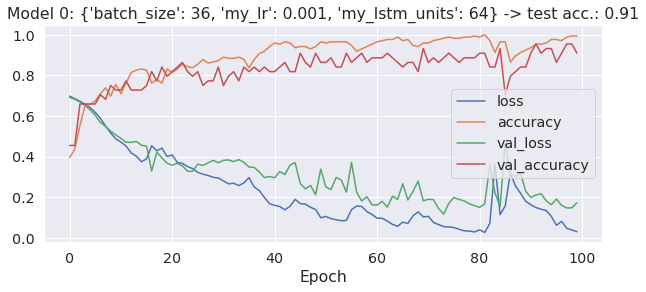

In [36]:
evaluate_model(0)

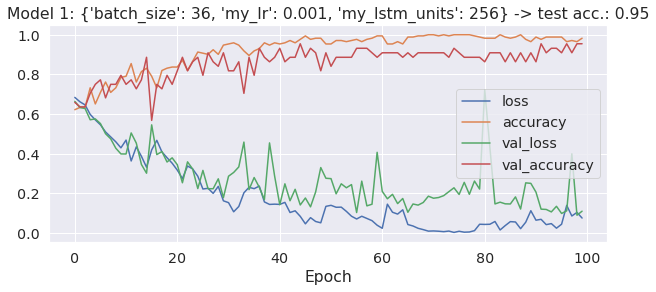

In [37]:
evaluate_model(1)

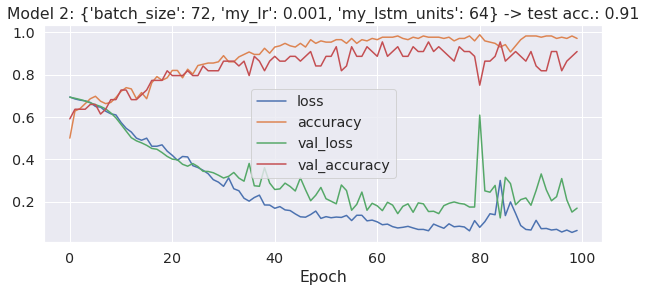

In [38]:
evaluate_model(2)